<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
pip install sklearn-lvq

In [109]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn_lvq import GlvqModel
from sklearn_lvq.utils import plot2d
from sklearn.mixture import GaussianMixture
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn_lvq import GlvqModel
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [110]:
#Para acomodar la información si viene por minuto y en registros, 
#df = pd.read_csv('rg1.csv')
## aqui agrupamos por minuto
#df_grouped_multiple = df.groupby(['YEAR','MONTH','DAY','HOUR']).agg({'RG1': ['mean']})
#df_grouped_multiple.columns = ['rg1_mean']
#df_grouped_multiple = df_grouped_multiple.reset_index()
## aquí pivoteamos
#df1 = df_grouped_multiple.pivot(index=['YEAR','MONTH','DAY'], columns='HOUR', values='rg1_mean').dropna()
#print(df1) #df1.to_csv('res.csv')
#df1.columns = [['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17', '18','19', '20', '21', '22', '23']]

In [111]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,ytitle_,xtitle_,dot_,namefile_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel(xtitle_, color=LETRASNARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)                
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [112]:
def scatterplot(X_,Y_,tags_,centers_,title_,namefile_ ):
    fig, ax1 = plt.subplots(figsize=(4,4))
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    for k in centers_:
        x = k[7]; y = k[8]
        plt.plot(x,y,"o",color="red",)
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('hora 7',  color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('hora 8',  color=LETRASNARA, fontsize='large')
    plt.scatter(X_, Y_, c=tags_, alpha=0.3)
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile_, transparent=True)
    plt.show()

In [113]:
def print_patrones(list_series,list_categorias,list_patrones,title_,namefile_): 
    cat = np.unique(list_categorias)
    n = math.ceil(pow(n_clusters, 0.5))
    fig, axs = plt.subplots(n, n, figsize=(15,14))
    row=0; col=0
    for c in cat:
        j = 0
        for g in list_categorias:    
            if c == g:
                axs[row,col].plot(list_series[j],alpha=0.5)
                axs[row,col].set_title(title_+str(c))
                #axs[row,col].xaxis.set_xlabel(horas_invierno)
            j = j + 1
        if len(list_patrones) != 0:
            axs[row, col].plot(list_patrones[c],alpha=0.7,color='red',linestyle='dashed',linewidth=4)
        col = col + 1
        if col == n:
            col = 0
            row = row + 1  
    plt.savefig(namefile_, transparent=True)
    plt.show()

# **Leemos datos fotovoltaicos**

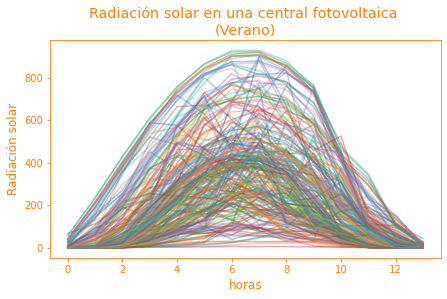

In [114]:
df = pd.read_csv('rg1_horas.csv')

##totales por dia ('SUMA'), diferenciados de primer orden ('dSUMA'), de segundo orden ('ddSUMA')
x_total   = df[['SUMA']].to_numpy()
dx_total  = df[['dSUMA']].to_numpy()
ddx_total = df[['ddSUMA']].to_numpy()

## Por estación del año
df_invierno = df[(df.MONTH==11)|(df.MONTH==12)|(df.MONTH==1)|(df.MONTH==2)|(df.MONTH==3)|(df.MONTH==4)]
df_verano   = df[(df.MONTH==5) |(df.MONTH==6) |(df.MONTH==7)|(df.MONTH==8)|(df.MONTH==9)|(df.MONTH==10)]
df = df_invierno
horas_verano   = ['4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']
horas_invierno = ['5','6','7','8','9','10','11','12','13','14','15','16','17','18']
X = df[horas_invierno].to_numpy()

#Normalizing the data
#sc = StandardScaler()
#X  = sc.fit_transform(X)
#y  = sc.fit_transform(Y)

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.3)

print_serie(X_train,'Radiación solar en una central fotovoltaica \n(Verano)','Radiación solar','horas',False,'fig_t13_all')

# **K-means**


y_kmeans [0 3 6 7 1 8 0 6 8 9 4 2 3 7 8 2 6 8 4 3 6 3 7 1 5 9 5 6 3 3 4 0 3 0 0 7 2
 4 4 5 6 8 3 7 3 0 3 6 9 9 6 5 3 8 8 5 6 3 7 8 8 7 5 5 3 9 5 2 5 9 6 3 5 5
 3 6 3 1 8 3 0 9 5 8 2 6 9 9 9 0 3 4 2 3 7 1 8 4 7 3 1 1 3 6 5 2 3 1] 108
y_kmeans_train [9 5 0 8 1 3 3 6 8 1 2 4 6 0 1 9 6 1 3 5 7 9 4 6 0 0 1 8 0 5 2 9 3 1 0 0 3
 8 6 2 8 6 6 9 7 6 7 3 3 8 6 6 6 1 9 6 2 4 3 0 4 1 2 3 7 6 7 0 8 8 9 6 6 8
 5 6 9 3 6 5 0 7 5 8 9 7 3 5 5 3 0 6 0 3 4 7 7 5 4 3 9 8 8 7 4 7 8 8 6 2 3
 8 6 3 3 2 9 3 7 8 7 0 3 6 3 4 0 2 0 0 9 9 3 7 7 9 9 5 9 5 5 4 7 4 0 6 1 8
 8 2 2 5 9 1 5 0 8 9 7 6 9 6 1 9 3 6 8 6 3 7 0 6 3 9 0 6 7 0 0 5 4 3 5 2 4
 6 5 7 8 8 5 2 4 8 1 6 4 8 3 3 7 5 3 3 6 8 2 8 3 3 8 6 3 3 8 1 8 7 7 6 3 3
 2 9 5 9 5 6 3 0 1 6 0 5 5 6 9 3 6 9 3 6 7 9 9 0 3 3 8 7 3 5] 252


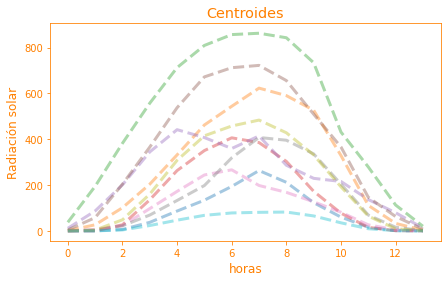

In [115]:
n_clusters = 10
k_means = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, n_init=10) # una variante MiniBatchKMeans, KMeans
k_means = k_means.fit(X_train)
values  = k_means.cluster_centers_.squeeze()
labels  = k_means.labels_
kmeans_centers_= k_means.cluster_centers_
#print('Centroides', centers_)
#print('Exactitud:', k_means.score(X_test))
y_kmeans = k_means.predict(X_test)
y_kmeans_train = k_means.predict(X_train)
print('y_kmeans' , y_kmeans,len(y_kmeans ))
print('y_kmeans_train' , y_kmeans_train,len(y_kmeans_train))
print_serie(kmeans_centers_,'Centroides','Radiación solar','horas',True,'fig_t13_centroids_kmeans')
#scatterplot(X_train[:,4],X_train[:,8],labels,centers_,'Radiación solar \n K-means \n(entrenamiento)','fig_t13_train')

X_train (kmeans)


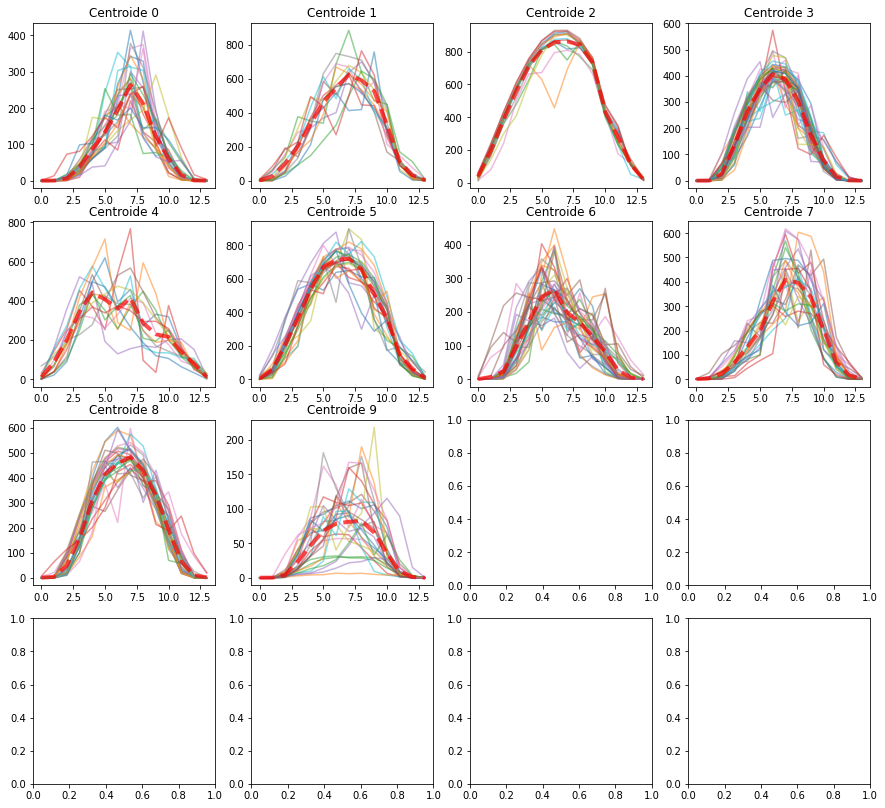

In [116]:
print('X_train (kmeans)')
print_patrones(list_series=X_train,list_categorias=y_kmeans_train,list_patrones=kmeans_centers_,title_='Centroide ',namefile_='fig_t13_kmeans_train')

X_test (kmeans)


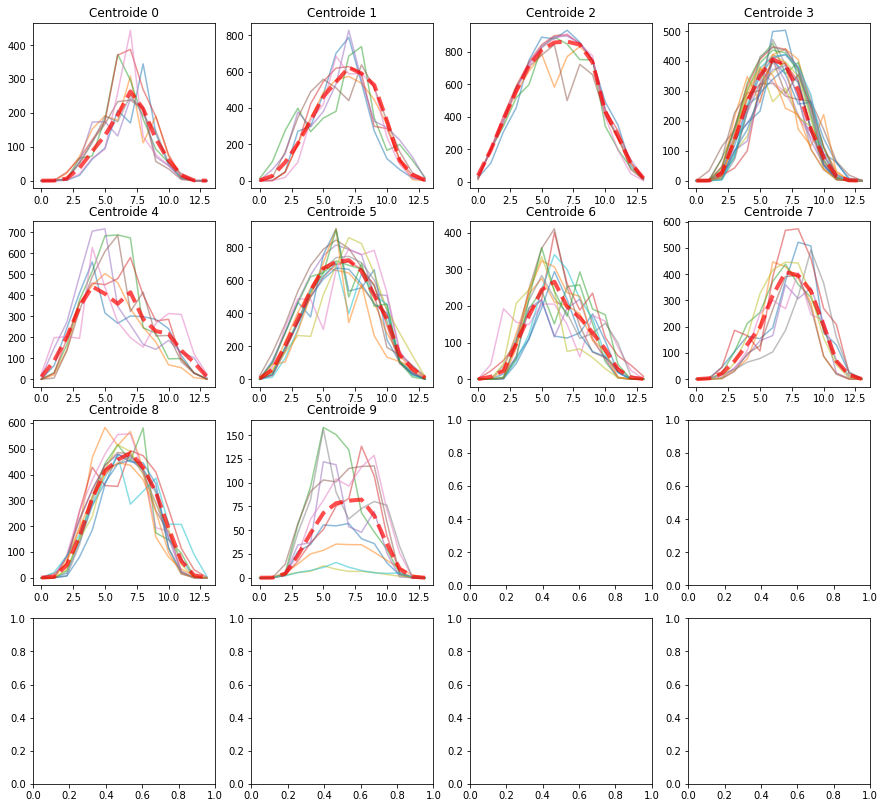

In [117]:
print('X_test (kmeans)')
print_patrones(list_series=X_test,list_categorias=y_kmeans,list_patrones=kmeans_centers_,title_='Centroide ',namefile_='fig_t13_kmeans_test')

# **KNN from scratch**


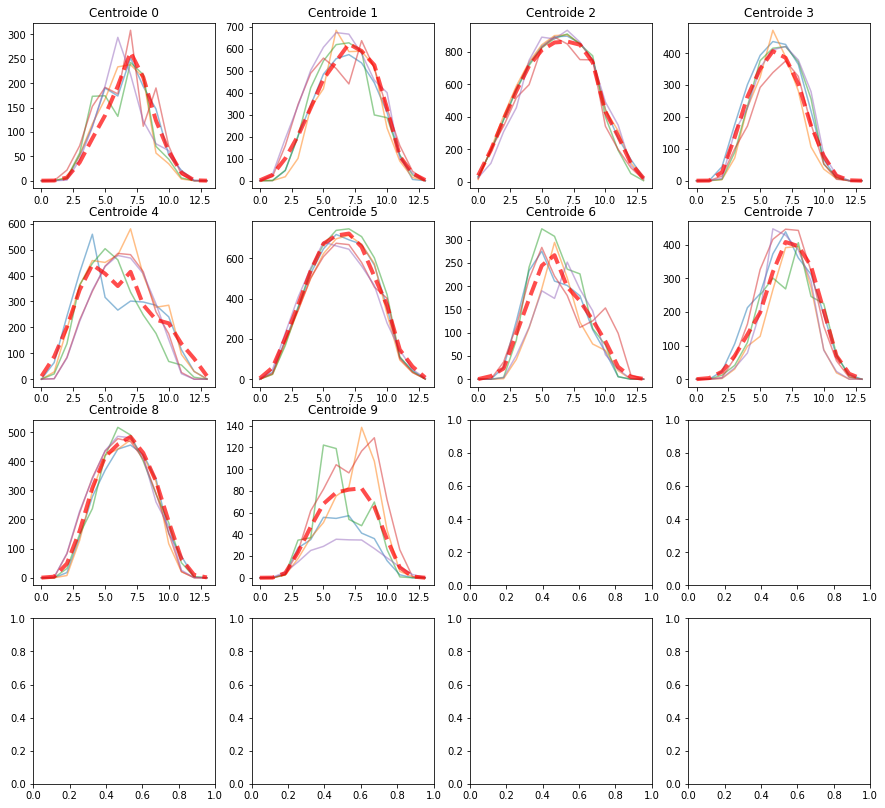

In [118]:
#https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)
   
dataset = [[2.7810836,2.550537003,0],	[1.465489372,2.362125076,0],	[3.396561688,4.400293529,0],	[1.38807019,1.850220317,0],[3.06407232,3.005305973,0],	[7.627531214,2.759262235,1],	[5.332441248,2.088626775,1],	[6.922596716,1.77106367,1],	[8.675418651,-0.242068655,1],[7.673756466,3.508563011,1]]

row0 = dataset[0]
#for row in dataset:
#	  distance = euclidean(row0, row)
#	  print(distance)
	 
## Encuentra los vecinos más cercanos
def get_neighbors(train, test_row, num_neighbors):
  
    distances = list()

    for train_row in train:
        dist = euclidean(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])

    neighbors = list()

    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

# Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	  neighbors = get_neighbors(train, test_row, num_neighbors)
	  output_values = [row[-1] for row in neighbors]
	  prediction = max(set(output_values), key=output_values.count)
	  return prediction

prediction = predict_classification(dataset, dataset[0], 3)

#neighbors = get_neighbors(dataset, dataset[0], 5)
serie = []
cat   = []
i     = 0 
for center in kmeans_centers_:
    neighbors = get_neighbors(X_test, center, 5)
    for neighbor in neighbors:
        serie.append(neighbor)
        cat.append(i)
    i = i  + 1
print_patrones(list_series=serie,list_categorias=cat,list_patrones=kmeans_centers_,title_='Centroide ',namefile_='fig_t13_knn_scratch')

# **KNN de aportaciones hidrológicas en presas**

position [106, 502, 178, 467, 286, 321, 478, 599, 226, 190, 69, 717, 153, 692, 58]


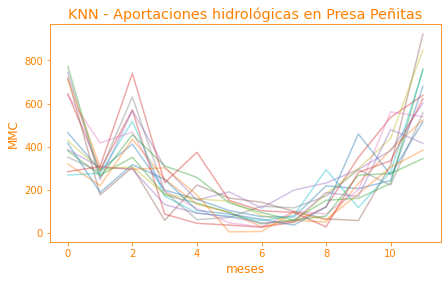

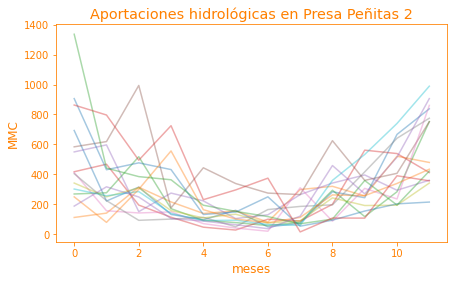

In [122]:
df = pd.read_csv('Aportaciones_Embalses.csv')
apor = df['PEA'].to_numpy()
v = 12                    ## tamanio de la ventana (un año)
k = 15                    ## número de vecinos a buscar k
vecindario    = []        ## vecindario completo
vecindario_b  = [] 
distances     = []
n = len(apor)
n = n - 24                ## test (comentar esta linea!!!)

#print(apor[n-v:n],'**') ## punto prototipo
## Se calcula la distancia euclidiana entre vecinos.
for i in range(n-2*v+1):
    dist = euclidean(apor[n-v:n],apor[i:i+v])
    distances.append((i, dist))
    #print(apor[n-v:n],apor[i:i+v],i, dist)

## Se ordena el vecindario por distancia de menor a mayor y se guardan las posiciones.
distances.sort(key=lambda tup: tup[1])
neighbors  = []
neighbors2 = []
position   = []

## Se escogen los k vecinos mas cercanos y guardamos las posiciones.
i = 0
for pos, dis in distances:
    neighbors.append(apor[pos:pos+v])
    neighbors2.append(apor[pos+v:pos+2*v])
    position.append(pos)
    #print(apor[pos:pos+v],dis,pos)
    i = i + 1
    if i == k:
        break

## Convertimos a numpy.  
neighbors  = np.array(neighbors)
neighbors2 = np.array(neighbors2)
#print('position',position)    ## posición de los k vecinos mas cercanos.
#print(neighbors)   ## k vecinos mas cercanos.
#print(neighbors2)  ## ventana de datos posterior a los k vecinos mas cercanos.

print_serie(neighbors, 'KNN - Aportaciones hidrológicas en Presa Peñitas','MMC','meses', False,'fig_t13_aportaciones')
print_serie(neighbors2,'Aportaciones hidrológicas en Presa Peñitas 2','MMC','meses', False,'fig_t13_aportaciones2')



# **LVQ**

In [ ]:
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_rslvq.html
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/index.html
#https://mrnuggelz.github.io/sklearn-lvq/modules/generated/sklearn_lvq.GlvqModel.html#sklearn_lvq.GlvqModel
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_glvq.html#sphx-glr-auto-examples-plot-glvq-py

print('GLVQ')
glvq = GlvqModel(prototypes_per_class=1, initial_prototypes=None)
glvq.fit(X_train,labels)
glvq_pred = glvq.predict(X_test)
glvq_pred_train = glvq.predict(X_train)
print('glvq_pred',glvq_pred)
print('glvq_pred_train', glvq_pred_train)
print('classification accuracy:', (glvq.score(X_test, glvq_pred)))
plt.show()

In [ ]:
print('X_train (LVQ)')
print_patrones(list_series=X_train,list_categorias=glvq_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_lvq_train')

In [ ]:
print('X_test (LVQ)')
print_patrones(list_series=X_test,list_categorias=glvq_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_lvq_test')

# **GaussianMixture**

In [ ]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
gm = GaussianMixture(n_components=n_clusters, init_params='kmeans',covariance_type='full') #full, tied, diag, spherical
gm.fit(X_train)
gm_pred_train = gm.predict(X_train)
gm_pred       = gm.predict(X_test)

print('classification accuracy train:', gm.score(X_train, gm_pred_train))
print('classification accuracy:', gm.score(X_test, gm_pred))

print('gm_pred',gm_pred)
print('gm_pred_train', gm_pred_train)

In [ ]:
print('X_train (GaussianMixture)')
print_patrones(list_series=X_train,list_categorias=gm_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_gm_train')

In [ ]:
print('X_test (GaussianMixture)')
print_patrones(list_series=X_test,list_categorias=gm_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_gm_test')

In [ ]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    ax.scatter(x, y)
    # now determine nice limits by hand:
    binwidth = 20
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(X_train[:,7],X_train[:,8], ax, ax_histx, ax_histy)

plt.show()

# **KNN**

In [ ]:
#https://scikit-learn.org/stable/modules/neighbors.html#classification
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(X_train)  #['auto','ball_tree','kd_tree','brute'].
distances, indices = nbrs.kneighbors(X_train)
print(distances, indices)
nbrs.kneighbors_graph(X_train).toarray()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, labels)
knn_pred_train = knn.predict(X_train)
knn_pred       = knn.predict(X_test)
print('knn_pred', knn_pred)
print('knn_pred_train',knn_pred_train )
print(knn.score(X_test,knn_pred))

In [ ]:
print('X_train (KNN)')
print_patrones(list_series=X_train,list_categorias=knn_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_knn_train')

In [ ]:
print('X_test (KNN)')
print_patrones(list_series=X_test,list_categorias=knn_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_knn_test')

# **Radiación solar diaria**

In [ ]:
#https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/
model=ARIMA(x_total,order=(1,0,1))
model_fit=model.fit()

forecast_dx = model_fit.predict(start=550,end=650,dynamic=False)

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(x_total,alpha=.5,color='red')
plt.plot(forecast_dx,alpha=.5,color='blue')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dx_total,alpha=.5,color='red')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(ddx_total,alpha=.5,color='red')
plt.show()

plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(dx_total, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(ddx_total, lags=10)
plt.show()


plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(y_kmeans_train, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(glvq_pred_train, lags=10)
plt.show()
plt.figure(figsize=(22, 5))
sm.graphics.tsa.plot_acf(gm_pred_train, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(knn_pred_train, lags=10)
plt.show()

In [ ]:
model=ARIMA(gm_pred_train  ,order=(1,0,1))
model_fit=model.fit()

forecast_dx = model_fit.predict(start=200,end=300,dynamic=True)
print(forecast_dx)